In [15]:
import cv2
import numpy as np
import os
import json
from matplotlib import pyplot as plt

with open("data/input.json", "r") as f:
    input_data = json.load(f)

image_paths = input_data["image_files"]


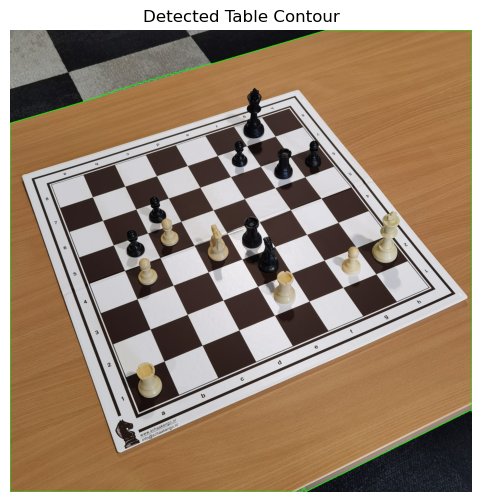

In [16]:
image = cv2.imread(image_paths[0])

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_brown = np.array([10, 30, 100])
upper_brown = np.array([30, 255, 255])

mask = cv2.inRange(hsv, lower_brown, upper_brown)

kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

table_contour = max(contours, key=cv2.contourArea)

contour_image = image.copy()
cv2.drawContours(contour_image, [table_contour], -1, (0, 255, 0), 3)

contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title("Detected Table Contour")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()


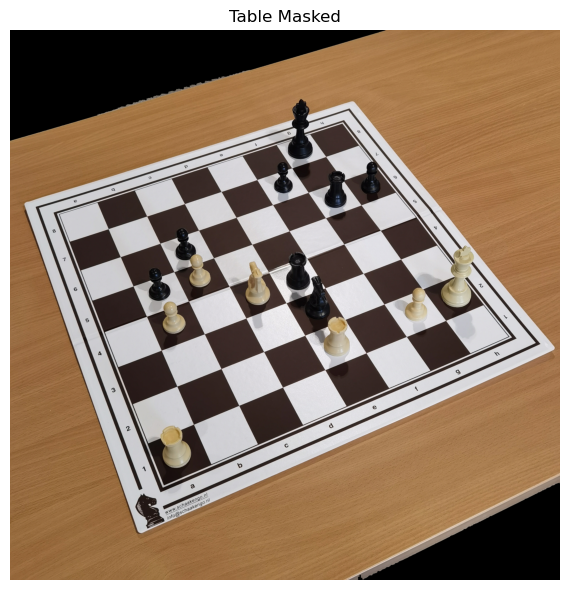

In [17]:
table_mask = np.zeros_like(image)
cv2.drawContours(table_mask, [table_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
masked_image = cv2.bitwise_and(image, table_mask)

masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

# Display both results side-by-side
plt.figure(figsize=(12, 6))

plt.plot(1, 2, 2)
plt.title("Table Masked")
plt.imshow(masked_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


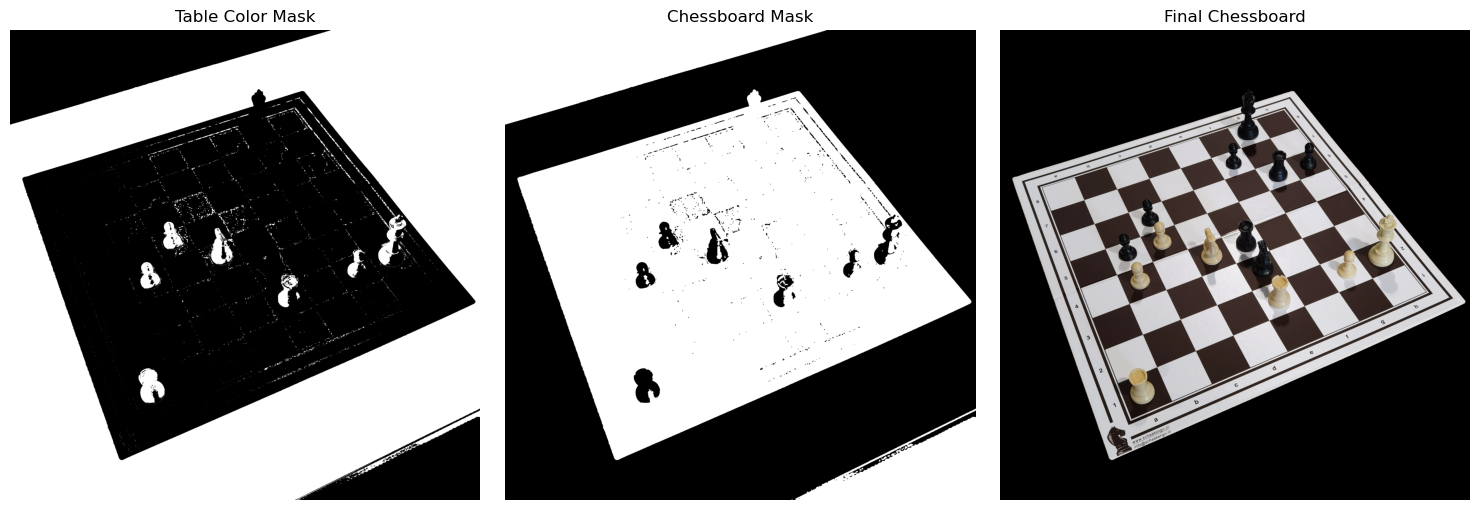

In [19]:

hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

lower_brown = np.array([10, 50, 50])   # Hue, Saturation, Value
upper_brown = np.array([30, 255, 200]) # Narrower range than before

table_color_mask = cv2.inRange(hsv, lower_brown, upper_brown)

chessboard_mask = cv2.bitwise_not(table_color_mask)

kernel = np.ones((3,3), np.uint8)
chessboard_mask = cv2.morphologyEx(chessboard_mask, cv2.MORPH_CLOSE, kernel)
chessboard_mask = cv2.morphologyEx(chessboard_mask, cv2.MORPH_OPEN, kernel, iterations=2)

contours, _ = cv2.findContours(chessboard_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    chessboard_contour = max(contours, key=cv2.contourArea)
    
    final_mask = np.zeros_like(chessboard_mask)
    cv2.drawContours(final_mask, [chessboard_contour], -1, 255, cv2.FILLED)
    
    chessboard_only = cv2.bitwise_and(masked_image, masked_image, mask=final_mask)
    
    # 
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Table Color Mask")
    plt.imshow(table_color_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Chessboard Mask")
    plt.imshow(chessboard_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Final Chessboard")
    final_rgb = cv2.cvtColor(chessboard_only, cv2.COLOR_BGR2RGB)
    plt.imshow(final_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No chessboard found - adjust color thresholds")